# Dogo Breeds classifier 

![alt_text](./display_images/background.jpg)

### You might think that recognizing dog breeds is an easy task for majority of people. Well not really.

### For instance take a look that these two images of a `Curly Coated Retriever` and an <br><br>`American Water Spaniel`.

![alt_text](./display_images/diff1.png)

### Look very similar don't they? Or what about these two?

![alt_text](./display_images/diff2.png)

### Doesn't look so easy now right does it? Let's go one step further and take a look at the next two images of <br><br>`American Staffordshire Terrier` with different light intensity and environment.

![alt_text](./display_images/diff3.png?raw=1)

 ### These two images are of same breed! The classification task would be very hairy to solve for a computer if <br><br>even as humans we can easily go wrong most of the times. So let's see how we can deduce to the <br><br>most efficient way of solving this problem.

## First Let's import all the necessary modules

In [1]:
import re
import random
import numpy as np
from PIL import Image, ImageFile
from os import path, getcwd, listdir, environ
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

Setting some environment and random variables to get reproducible results

In [2]:
%matplotlib inline
tf.random.set_seed(1)
environ['PYTHONHASHSEED']=str(1)
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Helper functions

In [3]:
def read_img(file_loc):
    img = Image.open(file_loc)
    return img

In [4]:
def print_random_images():
    fig=plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4
    title = ""
    
    for i in range(1, columns * rows +1):
        cat = random.choice(breeds)
        dir_path = path.join(data_dir, cat)
        loc = path.join(dir_path, random.choice(listdir(dir_path)))
        img = read_img(loc)
        title = re.search(r'\-(.*)', cat)
            
        axes = fig.add_subplot(rows, columns, i, title=title.group(0))
        fig.tight_layout(pad=1.0)
        axes.axis('off')
        title = ""
    
        plt.imshow(img)
        
    plt.show()

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')

In [6]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

In [23]:
def predict_breed(loc):
    breeds = listdir(loc)
    img_paths = [path.join(loc, x) for x in breeds]
    key_list = list(train_generator.class_indices.keys())
    
    # pick any image from directory
    p = random.choice(img_paths)
    img = Image.open(p)
    img = img.resize((299, 299))
    img = np.array(img) / 255
    
    pred = np.argmax(model.predict(img.reshape(1, 299, 299, 3)), axis=1)
    plt.title("Actual: " + re.search(r'\.\w(.*)', loc).group(0) +"  Predicted: " + re.search(r'\-(.*)', key_list[int(pred)]).group(0))
    plt.axis('off')
    plt.imshow(img)

## Data Preprocessing and visualization
<br>

In [4]:
data_dir = getcwd() + '/images/'
breeds = listdir(data_dir) # filenames of all the breeds

seed = 42
img_size = 299
batch_size = 32

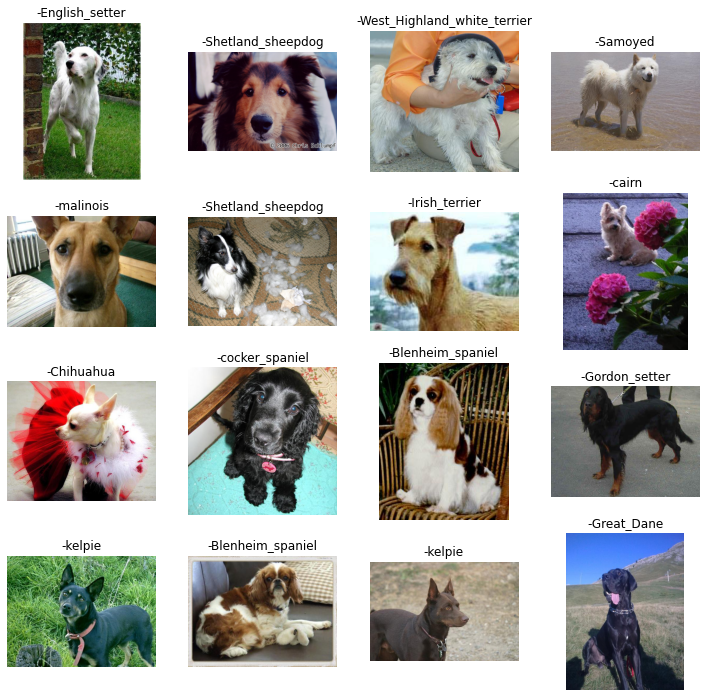

In [9]:
print_random_images()

* Let's print some random images 

In [7]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed) # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=seed) # set as validation data

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


### Conclusion 

* We have 120 categories
* There are 16,508 images in training set
* There are 4,072 images in validation set
* All categories:

In [11]:
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

* Deep learning algorithms are extremly are data hungry. The more data you have the better the algorithm will learn the differences. The amount of data we have for this classification task is not good enough. Simple convolutional networks will start to overfit the data by learning patterns in it instead of generalizing. Hence the model will be biased towards the training data.
<br><br>
* One of the main reason for this to happen is because our dataset is too small to find differences between 120 different breeds of dogs. Also there's a lot of noise in the dataet as you can see some images have more than one dog or some images also have human faces in them.
<br><br>
* As we know that the model is trained by maximizing it's accuracy on training dataset but it's performance is determined on its ability to perform well on unknown data.
<br><br>
*  In this situation our model just trying to memorize the training data as instead of trying to generalize from patterns observed in the training data.
<br><br>
* So to solve this problem we need more data, collecting which could take a lot of time. Another approach we can take is implement transfer learning where I will use some other state of the art CNN that has been  pre-trained on a big dataset.

## Transfer Learning - `InceptionV3 Network`

Transfer learning make use of the knowledge gained while solving one problem and applying it to a different but related problem.
For example, knowledge gained while learning to recognize cars can be used to some extent to recognize trucks.

I'm going to use InceptionV3 network which is trained on imagenet(a large dataset consisting about 14 million images).
InceptionV3 network is a very deep convolutional neural network which is over 48 layers deep with around 22 million parameters. So we will use this already trained parameters and add our own 120 classes classification layer at the last layer.

This network is a state of art CNN and generalises to this type of problem. The below image shows the architecture of InceptionV3.

![alt_text](./display_images/network.png)

In [12]:
# Creating the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False)

# freezing all the layers of Xception model by making them non trainable
for layer in base_model.layers:
    layer.trainable = False

# ADDING OUR NETWORK INCLUDING OUTPUT LAYER ON TOP

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# add a fully connected layer 120 neurons
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=6,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

Epoch 1/6
516/516 [==============================] - 462s 896ms/step - loss: 2.3888 - accuracy: 0.6190 - val_loss: 0.8767 - val_accuracy: 0.8568
Epoch 2/6
516/516 [==============================] - 455s 883ms/step - loss: 0.6630 - accuracy: 0.8679 - val_loss: 0.4968 - val_accuracy: 0.8777
Epoch 3/6
516/516 [==============================] - 456s 883ms/step - loss: 0.4463 - accuracy: 0.8871 - val_loss: 0.4295 - val_accuracy: 0.8730
Epoch 4/6
516/516 [==============================] - 458s 888ms/step - loss: 0.3764 - accuracy: 0.8921 - val_loss: 0.3992 - val_accuracy: 0.8804
Epoch 5/6
516/516 [==============================] - 465s 901ms/step - loss: 0.3380 - accuracy: 0.9006 - val_loss: 0.3794 - val_accuracy: 0.8841
Epoch 6/6
516/516 [==============================] - 463s 897ms/step - loss: 0.3063 - accuracy: 0.9065 - val_loss: 0.3760 - val_accuracy: 0.8814


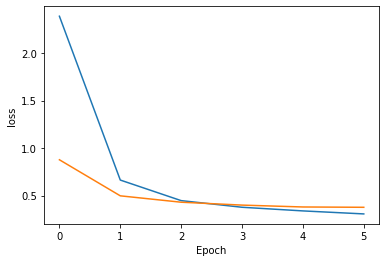

In [15]:
plot_loss(history)

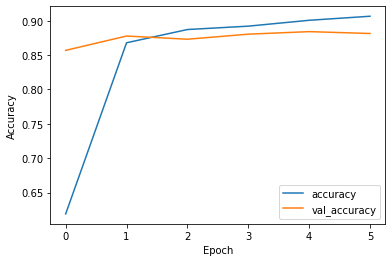

In [16]:
plot_accuracy(history)

## Conclusion

* Within just 6 epochs we able to get training accuracy of 91% and cross-validation accuracy of 88%.
* This is very good considering it's very close to human level accuracy.
* Let's save the model so that we can reuse it and we don't have to train again and again as training takes a lot of time.

In [17]:
# model.save('iv3_model.h5')
# model.save('./saved_models/iv3_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_models/iv3_model/assets


### Now let's print some images and their classified labels to see how well the algorithm does

In [5]:
model = models.load_model('./iv3_model.h5')

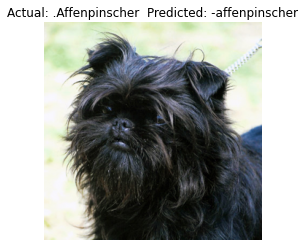

In [24]:
predict_breed('./test/001.Affenpinscher')

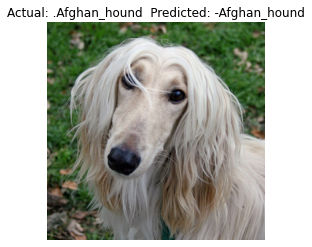

In [27]:
predict_breed('./test/002.Afghan_hound')

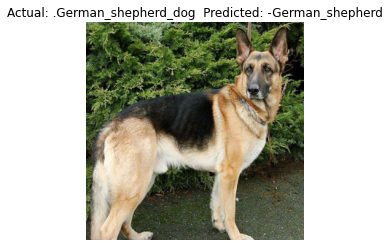

In [28]:
predict_breed('./test/071.German_shepherd_dog')

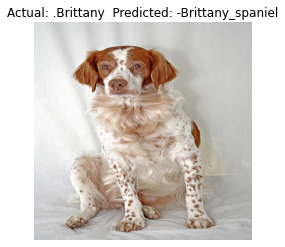

In [32]:
predict_breed('./test/037.Brittany')

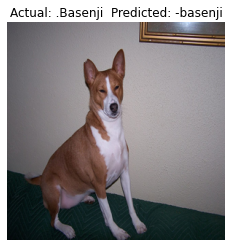

In [37]:
predict_breed('./test/014.Basenji')

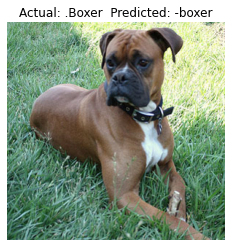

In [38]:
predict_breed('./test/034.Boxer')

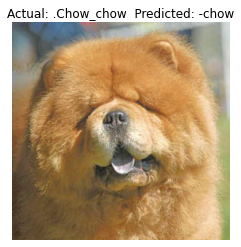

In [39]:
predict_breed('./test/051.Chow_chow')

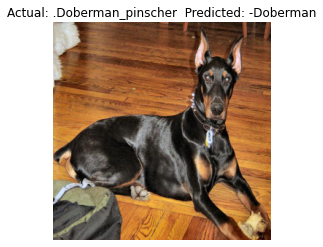

In [42]:
predict_breed('./test/059.Doberman_pinscher')

### You can test more categories in this pattern 

* Go to test directory
* Copy the folder name of the breed you want to test. Note that the test directory is not from the same dataset I just downloaded it from different dataset for testing purposes, so try to pick the categories that are present in the 120 breeds category map above.
* Create a snippet like predict_breed('./test/your_copied directory) paste it in the code cell below and run.